# Проект для «Викишоп»

***
### Задача:

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Метрика качества F1 должна быть не меньше 0.75.

### Описание данных:

Данные находятся в файле /toxic_comments.csv.

<br/>

***

### План работы:

**[Шаг 1.](#section_1)** Загрузка, анализ  и подготовка данных.

**[Шаг 2.](#section_2)** Обучение и проверка моделей.

**[Шаг 3.](#section_3)** Общий вывод

<br/>


<a id='section_1'></a>
### Шаг 1. Загрузка, анализ и подготовка данных

In [1]:
import pandas as pd
import re 
import nltk
import sys
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import(
    stopwords as nltk_stopwords,
    wordnet)
from sklearn.model_selection import(
    train_test_split, 
    GridSearchCV)

In [2]:
nltk.download('popular')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\ratus\AppData\Roaming\nl

True

In [3]:
#Сохраняем данные в датафрейм
data = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/11/toxic_comments.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.sample(5)

,Unnamed: 0,text,toxic
69167,69235,I should be unblocked because I didn't deserve...,0
89029,89112,betacommandbot not notifying contributor\nbeta...,0
98815,98911,"""\n\n Wikipedia Admins Use Gestapo Tactics to ...",0
29285,29322,"""\nSorry, it is at the end of the """"2008 lull""...",0
73327,73398,=Anti-Pederasty\n\nSome Catholics accuse Non-C...,0


Полученный датафрейм содержит 169292 комментариев. Пустых значений в датафрейме нет. 

Названия соответствуют стилю snake_case. С типами данных все в порядке.

Проверим наличие дубликатов:

In [6]:
print (data.duplicated().sum())

0


Дубликатов нет.

Посмотрим на соотношение классов в целевом признаке:

Относительные значения частоты классов:
0    0.898388
1    0.101612
Name: toxic, dtype: float64 



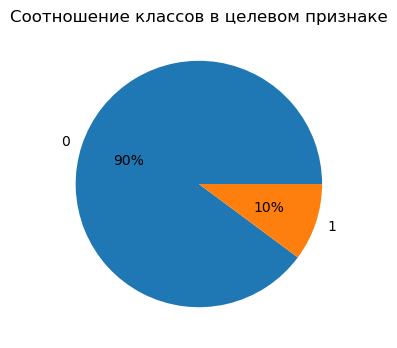

In [7]:
class_frequency = data['toxic'].value_counts(normalize=True)
print('Относительные значения частоты классов:')
print (class_frequency, '\n');

#Отобразим на графике
class_frequency.plot(
    kind='pie', 
    figsize = (4,4),
    title = 'Соотношение классов в целевом признаке',
    xlabel = ' ',
    ylabel = ' ',
    autopct='%1.0f%%',
    
);

Видно что в нашем датафрейме токсичных комментариев существенно меньше чем других - дисбаланс классов налицо.

Очистим и лемматизируем текст, оставив только буквы и пробелы: 

In [8]:
def clear_text(text):
    """
    Функция, которая приводит к нижнему регистру 
    и оставляет к тексте только нужные буквы и пробелы
    """
    text = text.lower()
    clear_list = re.sub(r'[^a-z ]', ' ', text)
    clear_text = " ".join(clear_list.split())
    return clear_text

In [9]:
data['corrected_text'] = data['text'].apply(clear_text)

In [10]:
def get_wordnet_pos(word):
    """
    Сопоставление тега POS с первым символом части речи WordNet
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
m = WordNetLemmatizer()

def lemmatize_pos(text):
    """
    Функция для лемматизации текста
    с соответствующим POS-тегом
    """
    #Сначала мы разобъем предложение на слова с помощью tokenize, 
    #а затем вызываем.lemmatize() для каждого слова
    words_list = nltk.word_tokenize(text)
    lemm_text = " ".join([m.lemmatize(word,get_wordnet_pos(word)) for word in words_list])
    return lemm_text

In [12]:
%%time
data['corrected_text'] = data['corrected_text'].apply(lemmatize_pos)

CPU times: total: 52min 55s
Wall time: 58min 11s


Сохраняю себе в файл, чтобы не прогонять постоянно:

In [13]:
data.to_csv('corrected_data_nlp')

In [14]:
#Глянем результат:
data.head()

,Unnamed: 0,text,toxic,corrected_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разделим данные на обучающую и тестовую выборку:

In [15]:
features = data['corrected_text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=123)

In [16]:
#Проверяем размеры выборок:
print (features_train.shape, features_test.shape)

(127433,) (31859,)


Вычислим матрицу TF-IDF по корпусу наших текстов, учитывая стоп-слова:

In [17]:
stopwords = set(nltk_stopwords.words('english'))
#создаем счетчик указаав стоп слова
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

#получаем tf-idf для обучающей и тестовой выборки:
tf_idf_train = count_tf_idf.fit_transform(features_train) 
tf_idf_test = count_tf_idf.transform(features_test) 

<a id='section_1'></a>
### Шаг 2. Обучение и проверка моделей

Попробуем простые модели LogisticRegression и  DecisionTreeClassifier.

Для борьбы с дисбалансом применим взвешивание.

Метрика у нас F1 должна быть не меньше 0.75.

#### 2.1 Модель логистической регрессии

In [18]:
%%time

#Cоздаем словарик, содержащий параметры, которые будем подбирать GridSearch’ем
parametrs_log = { 
    'solver': ['liblinear','newton-cg'],
    'C': [0.1,1,5,10],
    'max_iter' : [150,200]
}

#Запускаем обучение
grid_lr = GridSearchCV(
    LogisticRegression(random_state=123,class_weight='balanced'), 
    parametrs_log,
    scoring='f1',
    n_jobs=-1
);
grid_lr.fit(tf_idf_train, target_train);

#Записываем лучший результат:
best_params_log = grid_lr.best_params_
best_model_lr = grid_lr.best_estimator_

print ('лучшие параметры', best_params_log)
print ('Метрика F1 на тренировочной выборке = {:.2f}'.format(grid_lr.best_score_))

лучшие параметры {'C': 5, 'max_iter': 150, 'solver': 'liblinear'}
Метрика F1 на тренировочной выборке = 0.76
CPU times: total: 13.9 s
Wall time: 1min 5s


Уже даже на простой модели логистической регрессии мы получили не меньше 0.75, понятное дело что это только на обучающих данных, но очень неплохо.

#### 2.2 Модель дерева решений

In [19]:
%%time

#Cоздаем словарик, содержащий параметры, которые будем подбирать GridSearch’ем
parametrs_tree = { 'max_depth': range (2,18,4),
            'min_samples_leaf': range (2,10,4)}

#Запускаем обучение
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=123, class_weight='balanced'), 
    parametrs_tree, 
    scoring='f1',
    n_jobs=-1
);
grid_tree.fit(tf_idf_train, target_train);

#Записываем лучший результат:
best_params_tree = grid_tree.best_params_
best_model_tree = grid_tree.best_estimator_

print ('лучшие параметры', best_params_tree)
print ('Метрика F1 на тренировочной выборке = {:.2f}'.format(grid_tree.best_score_))

лучшие параметры {'max_depth': 14, 'min_samples_leaf': 6}
Метрика F1 на тренировочной выборке = 0.60
CPU times: total: 22.1 s
Wall time: 4min 26s


Модель дерева решения показала результат значительно хуже (F1 = 0.60). Для тестирования выберем логистическую регрессию:

#### 2.3 Тестирование модели

In [20]:
predicted_test = best_model_lr.predict(tf_idf_test)

f1_test = f1_score(target_test, predicted_test)
print(f' Метрика качества F1 на тестовой выборке = {f1_test:.2f}')

 Метрика качества F1 на тестовой выборке = 0.76


О, отлично, модель показала очень хорошее качество, не мешьше 0.75 как и необходимо заказчику.


<a id='section_3'></a>
### Шаг 3. Общий вывод.

#### Цели исследования

Необходимо обучить модель классификации комментариев на позитивные и негативные. Метрика качества F1 должна быть не меньше 0.75.  

<br/> 

#### Полученные данные были изучены и прошли следующую предобработку:

* Полученный датафрейм содержит 169292 комментариев. Пустых значений в датафрейме нет.

* Названия соответствуют стилю snake_case. 

* С типами данных все в порядке.

* Дубликатов в датафрейме нет.

* Видно что в нашем датафрейме токсичных комментариев существенно меньше чем других - дисбаланс классов налицо:

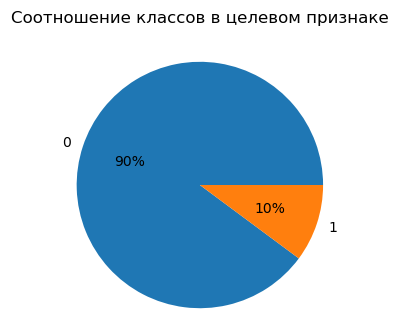

* Текст был очищен (оставили только буквы и пробелы) и лемматизирован.

* Данные были разделены на обучающую и тестовую выборку (80/20%).

* Также были вычислена матрицу TF-IDF по корпусу наших текстов, учитывая стоп-слова.

<br/> 


#### Обучение и проверка моделей:

Были опробованы простые модели LogisticRegression и DecisionTreeClassifier.

Для борьбы с дисбалансом применялось взвешивание. Метрика у нас как и заявлено в целях F1.

Гиперпараметры моделей подбирались с помощью GridSearchCV.

* Для модели логистической регрессии лучшие параметры {'C': 5, 'max_iter': 150, 'solver': 'liblinear'}
    Метрика F1 на тренировочной выборке = 0.76

Уже даже на простой модели логистической регрессии мы получили не меньше 0.75, очень неплохо.

* Для модели дерева решений лучшие параметры {'max_depth': 14, 'min_samples_leaf': 6}
    Метрика F1 на тренировочной выборке = 0.60

Модель дерева решения показала результат значительно хуже. Для тестирования была выбрана логистическая регрессия.

**Тестирование:**
Значение метрики F1  на тестовых данных = 0.76. Модель показала очень хорошее качество, не мешьше 0.75 как и необходимо заказчику.

<br/>

### Вывод и рекомендации:

По итогу работы можно рекомендовать модель логистической регрессии, с указанными выше характеристиками для классификации комментариев.

Мы надеемся, что данная модель поможет улучшить работу сервиса, и готовы провести дополнительное исследование, если текущий результат недостаточен.

<br/>